In [123]:
import pandas as pd
import json
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sn
import matplotlib.pyplot as plt

In [124]:
## replace the consecutive 0s (over 10) with np.NaN in each column
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=10):
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

In [125]:
## Newey-West Adjustment For a Time-Series Data, e.g. Lambdas (factor returns)
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

In [126]:
## Stock return and firm characteristics data contain lots of NAs, which will cause SVD not converge, thus the following GRS test can't be used in testing the joint distribution
## of alphas (mis-pricing errors). The alternative test that we used here is "alpha test" in Fama&French (2019).


In [127]:
"""
Function GRS_test(factor, resid, alpha) is to conduct GRS test according 
to Gibbons, Ross & Shanken(1989) to receive GRS-statistic and p-value.

H0: alpha1=alpha2=...=alphaN=0

Parameters:
  T = number of months
  N = number of portfolios/stocks
  L = number of factors

Inputs:
  factor: matrix of FF factors with shape (T, L)
  resid: matrix of residuals with shape (T, N)
  alpha: matrix of intercepts with shape (N, 1)

Outputs:
  f_grs: GRS-statistic
  p_grs: P-value

"""
from scipy.stats import f

def GRS_test(factor, resid, alpha):
    N = resid.shape[1]        
    T = resid.shape[0]       
    L = factor.shape[1]      

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1)
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    # pinv.linalg.pinv is a pseudoinverse not a real one, for calculating the real inverse we need to use np.linalg.inv
    # However, the structure of resids matrix is oftenly a Singular matrix (one for which a inverse matrix does not exis)
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.pinv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.inv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - stats.f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs


In [128]:
## In Fama&French (2020), they use firm characteristics as factor loadings and then conduct TS and CS regression to 
## test the explanatory power of pure factor returns. And then they compare these two new FF5CS-Factor asset pricing models with 
## the traditional FF5TS-Factor Model(2015).

## Compare TS and CS Models

### Time-Series Factor Model I

In [129]:
## Step-1: Use double-sorted portfolio return as regressors and then run time-series regression model to obtain factor loadings and interceptions, i.e. betas and alphas, with NW Adjustment
## Step-2: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 


In [130]:
df_FF3 = pd.read_csv('df_FF3.csv')
df_FF3.Dates = df_FF3.Dates.apply(lambda x:x[:10])
df_FF3.set_index('Dates',inplace=True)
df_FF3 = df_FF3.rename(columns={'MR_RF':'MKT'})
df_FF3

,MKT,SMB,HML
Dates,,,
2000-12-20,-0.0083,0.001267,0.00510
2000-12-21,-0.0062,0.001933,-0.00240
2000-12-22,0.0163,0.002433,0.00670
2000-12-25,-0.0003,0.000000,0.00000
2000-12-26,-0.0003,0.000000,0.00000
...,...,...,...
2019-02-27,0.0008,-0.003700,-0.00155
2019-02-28,-0.0055,0.005000,-0.00145
2019-03-01,0.0034,-0.003433,0.00380


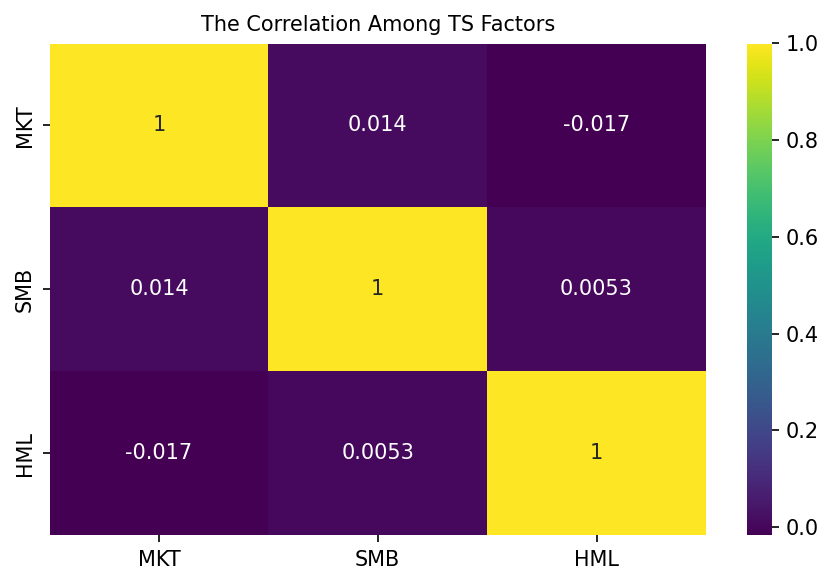

In [131]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF3.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

In [132]:
df_FF5 = pd.read_csv('df_FF5.csv')
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])
df_FF5.set_index('Dates',inplace=True)
df_FF5 = df_FF5.rename(columns={'MR_RF':'MKT'})

In [133]:
df_FF5

,MKT,SMB,HML,RMW,CMA
Dates,,,,,
2000-12-20,-0.0083,-0.0003,0.0052,-0.0016,0.0014
2000-12-21,-0.0062,0.0041,-0.0024,0.0004,0.0131
2000-12-22,0.0163,0.0027,0.0066,-0.0013,-0.0034
2000-12-25,-0.0003,0.0000,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...
2019-02-27,0.0008,-0.0033,-0.0015,-0.0005,-0.0010
2019-02-28,-0.0055,0.0032,-0.0015,0.0113,-0.0001
2019-03-01,0.0034,-0.0028,0.0037,0.0033,0.0052


In [134]:
m_df_FF5 = df_FF5
m_df_FF5['month'] = np.array(df_FF5.index.astype(str).str[:7])
m_df_FF5 = m_df_FF5.groupby('month').sum()
df_FF5 = df_FF5.drop(['month'], axis = 1)
# m_df_FF5 = m_df_FF5.iloc[:-1,:]
m_df_FF5

,MKT,SMB,HML,RMW,CMA
month,,,,,
2000-12,0.0107,-0.0029,0.0111,-0.0014,0.0021
2001-01,0.0851,-0.0018,-0.0045,-0.0324,0.0161
2001-02,-0.0068,0.0119,0.0353,0.0283,0.0519
2001-03,-0.0935,0.0192,0.0139,-0.0174,0.0412
2001-04,0.0921,-0.0157,0.0204,-0.0156,0.0160
...,...,...,...,...,...
2018-11,-0.0365,0.0014,-0.0235,0.0024,-0.0124
2018-12,0.0375,-0.0033,-0.0123,0.0085,0.0050
2019-01,0.0234,0.0057,0.0154,0.0151,0.0042


In [135]:
m_df_FF5.mean()*100

MKT    0.691045
SMB    0.205318
HML   -0.093909
RMW   -0.086682
CMA    0.052409
dtype: float64

In [136]:
m_df_FF5.std()

MKT    0.046434
SMB    0.013624
HML    0.017510
RMW    0.017026
CMA    0.017630
dtype: float64

In [137]:
m_df_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MKT,SMB,HML,RMW,CMA
0,2.207386,2.235227,-0.795491,-0.755142,0.440918
1,0.028325,0.026412,0.427189,0.450975,0.659708


In [138]:
df_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MKT,SMB,HML,RMW,CMA
0,1.898812,1.718062,-0.673935,-0.587993,0.366963
1,0.057650,0.085850,0.500385,0.556565,0.713663


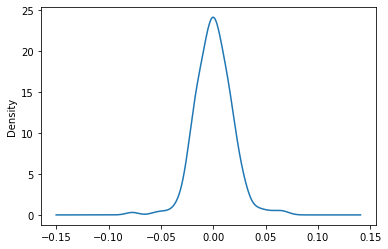

In [139]:
m_df_FF5.iloc[:,4].plot(kind='density')
# df_FF5.iloc[:,4].hist()
plt.show()

In [140]:
np.round(df_FF5.corr(), 4)

,MKT,SMB,HML,RMW,CMA
MKT,1.0000,0.0099,-0.0175,0.0109,0.0253
SMB,0.0099,1.0000,-0.0026,0.0033,-0.0212
HML,-0.0175,-0.0026,1.0000,-0.0069,0.0191
RMW,0.0109,0.0033,-0.0069,1.0000,-0.0003
CMA,0.0253,-0.0212,0.0191,-0.0003,1.0000


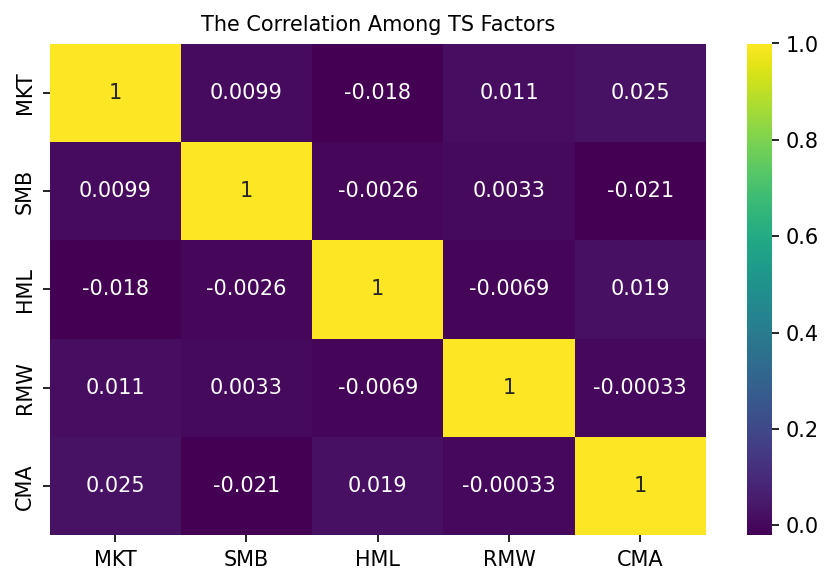

In [141]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

In [142]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])
df_SR

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.000000,-0.026116,NaN,-0.070618,NaN,NaN,-0.013234,NaN,-0.016129,NaN,...,0.000000,NaN,0.0,NaN,NaN,-0.109199,NaN,NaN,-0.104700,0.000000
2000-01-06,-0.080043,0.000000,NaN,-0.024693,NaN,NaN,0.034932,NaN,-0.033061,NaN,...,0.081967,NaN,0.0,NaN,NaN,-0.039221,NaN,NaN,0.000000,0.000000
2000-01-07,0.117783,-0.005900,NaN,0.048790,NaN,NaN,0.094951,NaN,-0.042925,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,-0.028988,0.000000
2000-01-10,0.068993,0.015656,NaN,0.000000,NaN,NaN,0.043488,NaN,0.074108,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.084557,0.029559
2000-01-11,-0.068993,0.000000,NaN,-0.048790,NaN,NaN,-0.088186,NaN,0.037740,NaN,...,0.081967,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-27,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.080043,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.016737,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [143]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR.dropna(axis = 0, how = 'all')
df_SR = df_SR.apply(replacer)

In [144]:
df_Ex_SR = df_SR - df_RF.values
df_Ex_SR = df_Ex_SR.loc[df_FF5.index,:]
df_Ex_SR

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.118048,-0.000265,NaN,-0.000265,NaN,NaN,-0.081503,NaN,-0.000265,NaN,...,-0.000265,NaN,NaN,NaN,NaN,-0.000265,NaN,NaN,-0.000265,-0.000265
2000-12-21,-0.000265,-0.007434,NaN,-0.000265,NaN,NaN,0.044859,NaN,-0.000265,NaN,...,NaN,NaN,NaN,NaN,NaN,0.056893,NaN,NaN,-0.000265,-0.000265
2000-12-22,-0.000267,0.002128,NaN,-0.000267,NaN,NaN,0.028736,NaN,-0.000267,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.057426,NaN,NaN,-0.000267,-0.000267
2000-12-25,-0.000267,-0.000267,NaN,-0.000267,NaN,NaN,-0.000267,NaN,-0.000267,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.000267,NaN,NaN,-0.000267,NaN
2000-12-26,-0.000267,-0.000267,NaN,-0.000267,NaN,NaN,-0.000267,NaN,-0.000267,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.000267,NaN,NaN,-0.000267,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,NaN,NaN,NaN,-0.000189,0.002766,NaN,NaN,-0.000189,...,NaN,NaN,0.083193,0.014063,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN,NaN,-0.000189,-0.000189,NaN,NaN,-0.000189,...,NaN,NaN,-0.000189,-0.002550,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN,NaN,NaN,-0.000188,0.054345,NaN,NaN,-0.000188,...,NaN,NaN,-0.000188,0.013897,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# FF5-Factor Time Series Regression with Newey-West Adjustment
all_betas = []
all_cons_ts = []
all_std_errs = []
all_Rs = []
all_sd_res = []

betas = []
labels = []
cons_ts = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR.loc[:, j].dropna().index).intersection(df_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})

        b = list(res.params)
        t = res.tvalues[0]
        se = res.bse[0]
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        cons_ts.append(t)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_cons_ts.append(pd.DataFrame(cons_ts))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs.append(pd.DataFrame(Rs))
all_sd_res.append(pd.DataFrame(sd_res))

100%|██████████| 740/740 [00:04<00:00, 180.50it/s]


In [146]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ZSA.SJ.Equity   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.204
Date:                Sun, 17 Apr 2022   Prob (F-statistic):              0.305
Time:                        00:58:26   Log-Likelihood:                 7115.7
No. Observations:                2330   AIC:                        -1.422e+04
Df Residuals:                    2324   BIC:                        -1.418e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.684      0.494      -0.000       0.001
MKT            0.0121      0.016      0.759      0.448      -0.019       0.043
SMB            0.0624      0.066      0.945      0.345      -0.067       0.192
HML            0.0199      0.051      0.391      0.696      -0.080       0.120
RMW           -0.0233      0.046     -0.509      0.611      -0.113       0.066
CMA            0.1010      0.048      2.120      0.034       0.008       0.194
==============================================================================
Omnibus:                      411.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7222.062
Skew:                           0.280   Prob(JB):                         0.00
Kurtosis:                      11.607   Cond. No.                         267.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [147]:
TS_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
TS_betas.columns = ['Intercepts','MKT','SMB','HML','RMW','CMA','Stocks']
TS_betas = TS_betas.set_index('Stocks')
TS_betas

,Intercepts,MKT,SMB,HML,RMW,CMA
Stocks,,,,,,
ABC.SJ.Equity,-0.003048,-0.334855,-1.038481,2.287313,1.736295,0.155451
ABI.SJ.Equity,0.000293,0.250634,-0.027526,-0.026816,-0.052584,0.015525
ABK.SJ.Equity,-0.002319,0.223503,-2.430166,2.617665,1.897113,0.505996
ABR.SJ.Equity,-0.006584,-0.389331,3.760604,-0.545912,1.553621,-0.163119
ABU.SJ.Equity,-0.000460,0.013298,0.056566,0.179378,-0.216206,-0.083836
...,...,...,...,...,...,...
ZGOVI.SJ.Equity,0.000053,0.048067,-0.005870,-0.025272,-0.036429,-0.027054
ZPT.SJ.Equity,-0.002632,0.100060,-0.095590,-0.209509,0.405521,-0.727316
ZRNHDG.SJ.Equity,-0.000383,0.030242,0.154120,0.025129,-0.110328,-0.119765


In [148]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
TS_alphas = TS_betas.iloc[:,0]
TS_alphas.describe()

count    708.000000
mean      -0.000724
std        0.002416
min       -0.019502
25%       -0.000787
50%       -0.000082
75%        0.000244
max        0.006842
Name: Intercepts, dtype: float64

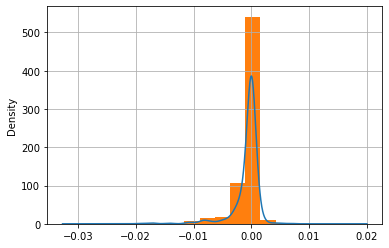

In [149]:
TS_alphas.plot(kind='density')
TS_alphas.hist()
plt.show()

In [150]:
all_cons_ts[0]

,0
0,-1.128583
1,0.932694
2,-1.452077
3,-2.011185
4,-0.748997
...,...
703,0.495672
704,-2.008599
705,-1.121602
706,0.333480


In [151]:
all_ses = pd.DataFrame(all_std_errs[0])
all_ses.index = TS_alphas.index
all_ses.columns = ['std_errs']
all_ses

,std_errs
Stocks,
ABC.SJ.Equity,0.002701
ABI.SJ.Equity,0.000314
ABK.SJ.Equity,0.001597
ABR.SJ.Equity,0.003274
ABU.SJ.Equity,0.000614
...,...
ZGOVI.SJ.Equity,0.000106
ZPT.SJ.Equity,0.001310
ZRNHDG.SJ.Equity,0.000342


In [152]:
TS_alphas_t = pd.concat([all_cons_ts[0], pd.DataFrame(labels)], axis = 1)
TS_alphas_t.columns = ['t-statistics','Stocks']
TS_alphas_t = TS_alphas_t.set_index('Stocks')
TS_alphas_t

,t-statistics
Stocks,
ABC.SJ.Equity,-1.128583
ABI.SJ.Equity,0.932694
ABK.SJ.Equity,-1.452077
ABR.SJ.Equity,-2.011185
ABU.SJ.Equity,-0.748997
...,...
ZGOVI.SJ.Equity,0.495672
ZPT.SJ.Equity,-2.008599
ZRNHDG.SJ.Equity,-1.121602


#### Results_1

In [153]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TS_alphas))*21*100,np.nanmean(abs(TS_alphas_t)))
### The mis-pricing errros is about 0.04% daily return, which is strongly significant

2.4473105113330336 1.2311180418810375


In [154]:
### Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = np.var(df_SR.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TS_alphas))/cs_var)


0.9212533564720019


In [155]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean(pd.DataFrame(np.square(TS_alphas).values)-pd.DataFrame(np.square(all_ses).values))
print(A_lamda/cs_var)

0    0.732419
dtype: float64


/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [156]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs)), 'As(a): ' + str(np.mean(all_ses.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res)*np.sqrt(21)))

AR^2: 0.06929980236597638 As(a): 0.0035768601563833523 As(e): 0.12838075864403103


In [157]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(TS_alphas)/np.var(df_Ex_SR.mean()))

0.13954636238873908

### Cross-section Factor Model I

In [158]:
## Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt and four pure factor returns;
## Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t+beta,i*lambda,t), t=1,2,3,...,T, Vi
## Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics
## Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 


In [159]:
## Import 18 double-sorted portfolios returns

In [160]:
ols_model = LinearRegression()

In [161]:
df_18_PR = pd.read_csv('df_18_PR.csv')
df_18_PR.Dates = df_18_PR.Dates.apply(lambda x:x[:10])
df_18_PR.set_index('Dates',inplace=True)

In [162]:
df_18_PR

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.0073,-0.0060,-0.0009,-0.0023,-0.0005,-0.0015,-0.0062,-0.0036,-0.0100,0.0022,0.0018,-0.0145,-0.0047,-0.0025,-0.0024,-0.0034,-0.0029,-0.0023
2000-12-21,-0.0117,0.0029,-0.0113,-0.0101,-0.0115,-0.0102,0.0039,-0.0145,-0.0099,-0.0054,-0.0077,-0.0010,-0.0020,-0.0041,-0.0026,0.0012,-0.0053,-0.0111
2000-12-22,0.0099,0.0028,0.0002,-0.0040,0.0139,0.0072,0.0021,-0.0022,0.0051,0.0110,0.0017,0.0075,0.0031,0.0043,-0.0055,0.0015,0.0107,0.0052
2000-12-25,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-12-26,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.0046,-0.0023,0.0026,0.0034,0.0008,0.0024,0.0046,-0.0011,0.0003,-0.0056,-0.0001,-0.0005,-0.0028,-0.0002,-0.0008,-0.0011,-0.0087,0.0051
2019-02-28,-0.0065,-0.0079,0.0032,0.0003,-0.0054,-0.0055,-0.0038,-0.0009,-0.0054,0.0016,0.0075,-0.0052,0.0064,0.0006,-0.0103,-0.0023,0.0027,-0.0004
2019-03-01,0.0093,-0.0046,-0.0010,0.0002,0.0056,-0.0022,0.0047,-0.0043,0.0013,-0.0059,0.0023,-0.0030,0.0004,-0.0006,-0.0037,0.0034,-0.0047,-0.0036


In [163]:
## Import Firm Characteristics of 18 double-sorted portfolios

In [164]:
df_18_std_Size = pd.read_csv('df_18_std_size.csv')
df_18_std_Size.Dates = df_18_std_Size.Dates.apply(lambda x:x[:10])
df_18_std_Size.set_index('Dates',inplace=True)
df_18_std_Size

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.781312,-0.090458,1.848094,1.815374,-0.512456,-0.539452,-0.085595,2.283493,-0.529163,0.053609,-0.920952,-0.266229,-0.185330,-1.305537,-0.221338,-0.737976,-0.327963,0.503191
2000-12-21,-0.781312,-0.090458,1.848094,1.815374,-0.512456,-0.539452,-0.085595,2.283493,-0.529163,0.053609,-0.920952,-0.266229,-0.185330,-1.305537,-0.221338,-0.737976,-0.327963,0.503191
2000-12-22,-0.781312,-0.090458,1.848094,1.815374,-0.512456,-0.539452,-0.085595,2.283493,-0.529163,0.053609,-0.920952,-0.266229,-0.185330,-1.305537,-0.221338,-0.737976,-0.327963,0.503191
2000-12-25,-0.781151,-0.079474,1.850319,1.826738,-0.513155,-0.540065,-0.087661,2.273843,-0.529809,0.051098,-0.920344,-0.267716,-0.187077,-1.304010,-0.222969,-0.737953,-0.329854,0.499240
2000-12-26,-0.781046,-0.072916,1.851627,1.833502,-0.513567,-0.540425,-0.088893,2.268058,-0.530188,0.049598,-0.919971,-0.268601,-0.188117,-1.303084,-0.223941,-0.737932,-0.330980,0.496877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.119487,1.546268,1.219728,1.561739,-1.873820,0.925591,0.794177,0.806161,0.257729,-0.307066,-1.070146,0.035157,-0.631996,-0.982620,-0.504375,0.158873,-0.905899,0.089987
2019-02-28,-1.120516,1.545925,1.220317,1.561396,-1.874255,0.925393,0.794072,0.805870,0.257367,-0.305990,-1.070054,0.034886,-0.631920,-0.982048,-0.504543,0.159395,-0.905694,0.090398
2019-03-01,-1.121537,1.545585,1.220903,1.561055,-1.874687,0.925196,0.793969,0.805582,0.257008,-0.304922,-1.069963,0.034616,-0.631845,-0.981479,-0.504710,0.159913,-0.905489,0.090807


In [165]:
df_18_std_PE = pd.read_csv('df_18_std_PE.csv')
df_18_std_PE.Dates = df_18_std_PE.Dates.apply(lambda x:x[:10])
df_18_std_PE.set_index('Dates',inplace=True)
df_18_std_PE

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.474577,-0.596427,1.589434,1.332862,-0.036290,-0.166038,-0.785416,2.553218,-1.192850,0.558439,-0.839326,-1.097937,0.077891,-0.655950,-0.763018,-0.183795,-0.465047,0.195671
2000-12-21,0.488083,-0.579499,1.607375,1.319233,-0.018389,-0.133995,-0.780162,2.543136,-1.205060,0.544398,-0.843136,-1.102449,0.090430,-0.652080,-0.797120,-0.156331,-0.467808,0.143373
2000-12-22,0.529640,-0.589796,1.612475,1.280541,0.014783,-0.108110,-0.789886,2.512530,-1.225850,0.568047,-0.856767,-1.119877,0.102469,-0.660567,-0.814292,-0.141778,-0.465314,0.151752
2000-12-25,0.551065,-0.595016,1.614802,1.260246,0.031965,-0.094679,-0.794770,2.496185,-1.236381,0.580187,-0.863662,-1.128686,0.108686,-0.664834,-0.823029,-0.134212,-0.463931,0.156063
2000-12-26,0.564130,-0.598168,1.616119,1.247754,0.042469,-0.086460,-0.797704,2.486026,-1.242739,0.587572,-0.867821,-1.133999,0.112480,-0.667400,-0.828317,-0.129576,-0.463055,0.158689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.912531,-0.789055,-0.220451,-0.542673,-0.147525,-1.058409,-0.605954,-0.766705,-0.125978,-0.962525,1.547041,0.748977,2.423917,-0.225811,-0.722433,1.450073,0.803500,0.106542
2019-02-28,-0.912004,-0.789580,-0.221151,-0.542742,-0.148195,-1.058445,-0.605969,-0.767175,-0.126434,-0.959334,1.548040,0.745663,2.425584,-0.226983,-0.722001,1.445591,0.810998,0.104138
2019-03-01,-0.911462,-0.790103,-0.221840,-0.542804,-0.148841,-1.058479,-0.605974,-0.767637,-0.126874,-0.956164,1.549032,0.742338,2.427231,-0.228166,-0.721564,1.441149,0.818401,0.101757


In [166]:
df_18_std_OP = pd.read_csv('df_18_std_OP.csv')
df_18_std_OP.Dates = df_18_std_OP.Dates.apply(lambda x:x[:10])
df_18_std_OP.set_index('Dates',inplace=True)
df_18_std_OP

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.256084,0.237906,0.245898,0.241780,0.223827,0.228190,0.221341,0.238552,0.236203,0.251100,0.256273,0.245066,-4.006389,0.218152,0.245097,0.185385,0.236185,0.239349
2000-12-21,0.256084,0.237906,0.245898,0.241780,0.223827,0.228190,0.221341,0.238552,0.236203,0.251100,0.256273,0.245066,-4.006389,0.218152,0.245097,0.185385,0.236185,0.239349
2000-12-22,0.256084,0.237906,0.245898,0.241780,0.223827,0.228190,0.221341,0.238552,0.236203,0.251100,0.256273,0.245066,-4.006389,0.218152,0.245097,0.185385,0.236185,0.239349
2000-12-25,0.256059,0.237915,0.245878,0.241787,0.223802,0.228165,0.221316,0.238527,0.236178,0.251075,0.256248,0.245041,-4.006389,0.218247,0.245072,0.185360,0.236395,0.239324
2000-12-26,0.256044,0.237920,0.245866,0.241791,0.223787,0.228150,0.221301,0.238512,0.236163,0.251060,0.256233,0.245026,-4.006389,0.218304,0.245057,0.185346,0.236521,0.239309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.822343,0.190651,0.692564,0.233343,-1.633859,0.126999,0.338755,-2.246118,0.197442,0.744658,-0.061178,0.999833,0.669821,-0.491681,1.164673,0.893887,-0.639183,0.641739
2019-02-28,-1.819476,0.192292,0.693698,0.234584,-1.630909,0.128631,0.340308,-2.242932,0.198849,0.745867,-0.069338,1.000860,0.671239,-0.498761,1.165169,0.894908,-0.647910,0.642919
2019-03-01,-1.816610,0.193915,0.694811,0.235810,-1.627963,0.130246,0.341842,-2.239745,0.200240,0.747055,-0.077420,1.001863,0.672635,-0.505766,1.165644,0.895907,-0.656544,0.644080


In [167]:
df_18_std_INV = pd.read_csv('df_18_std_INV.csv')
df_18_std_INV.Dates = df_18_std_INV.Dates.apply(lambda x:x[:10])
df_18_std_INV.set_index('Dates',inplace=True)
df_18_std_INV

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.768570,-0.398832,1.031163,1.400032,-0.046577,-0.380944,-1.046655,1.388225,0.202530,0.412823,-2.160876,0.963404,0.287319,0.334560,-1.796433,-0.221710,0.134608,-0.871205
2000-12-21,0.768570,-0.398832,1.031163,1.400032,-0.046577,-0.380944,-1.046655,1.388225,0.202530,0.412823,-2.160876,0.963404,0.287319,0.334560,-1.796433,-0.221710,0.134608,-0.871205
2000-12-22,0.768570,-0.398832,1.031163,1.400032,-0.046577,-0.380944,-1.046655,1.388225,0.202530,0.412823,-2.160876,0.963404,0.287319,0.334560,-1.796433,-0.221710,0.134608,-0.871205
2000-12-25,0.768539,-0.398856,1.031130,1.399997,-0.046603,-0.380968,-1.046675,1.388190,0.202502,0.412794,-2.160889,0.963371,0.287290,0.334757,-1.796448,-0.221735,0.134831,-0.871226
2000-12-26,0.768520,-0.398870,1.031110,1.399975,-0.046619,-0.380983,-1.046687,1.388168,0.202485,0.412777,-2.160897,0.963351,0.287273,0.334875,-1.796457,-0.221750,0.134965,-0.871239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.069522,-0.159000,0.448745,0.143181,-1.315148,-0.636402,-0.887761,-0.243377,-0.581160,0.508384,0.064759,-0.671813,0.293570,2.396380,-0.387844,-0.765149,0.754837,2.107319
2019-02-28,-1.068774,-0.158231,0.448903,0.143600,-1.314676,-0.635661,-0.887531,-0.242751,-0.580637,0.510198,0.062881,-0.672476,0.292775,2.396644,-0.389196,-0.765775,0.752663,2.108043
2019-03-01,-1.068033,-0.157469,0.449060,0.144016,-1.314207,-0.634927,-0.887302,-0.242130,-0.580118,0.511996,0.061020,-0.673132,0.291987,2.396903,-0.390536,-0.766394,0.750507,2.108759


In [168]:
len(df_18_std_Size)==len(df_18_std_PE)==len(df_18_std_OP)==len(df_18_std_INV)==len(df_18_PR)

True

In [169]:
## Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt
## and four pure factor returns at each time t;

In [170]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
Dates = []
index_times = list(df_18_PR.T.columns)

for k in tqdm(df_18_PR.T.columns):
    # k is time t in 4750 days

    df_index = ((((df_18_std_Size.T.loc[:, k].replace(-np.inf, np.nan).dropna().index).
                 intersection(df_18_std_PE.T.loc[:, k].replace(-np.inf, np.nan).dropna().index)).
                 intersection(df_18_PR.T.loc[:, index_times[index_times.index(k)]].dropna().index)).
                intersection(df_18_std_OP.T.loc[:, k].dropna().index)).\
        intersection(df_18_std_INV.T.loc[:, k].dropna().index)

    if len(df_index) > 10:

        l = list(ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                           df_18_std_PE.T.loc[df_index, k],
                                           df_18_std_OP.T.loc[df_index, k],
                                           df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                               (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).coef_)

        h = ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                      df_18_std_PE.T.loc[df_index, k],
                                      df_18_std_OP.T.loc[df_index, k],
                                      df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                          (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).intercept_

        lambdas.append(l)
        intercepts.append(h)
        Dates.append(k)

all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4750/4750 [00:24<00:00, 193.05it/s]


In [171]:
## Through performing FM-2 at each time t, we got the pure factor return time-series for MC/PE/OP/INV and intercept (Rzt)
df_CS_FF4 = pd.concat([all_lambdas[0], pd.DataFrame(Dates)], axis = 1)
df_CS_FF4.columns = ['Size','PE','OP','INV','Dates']
df_CS_FF4 = df_CS_FF4.set_index(['Dates'])
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.002219,0.005138,0.000221,-0.003126
2000-12-21,0.001642,-0.004612,-0.001245,-0.000050
2000-12-22,-0.004914,0.001391,0.000704,0.002304
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,0.000652,-0.000818,-0.000087,-0.000338
2019-02-28,0.001025,0.003372,-0.001396,0.002380
2019-03-01,-0.001015,0.000596,-0.000910,-0.001947


In [172]:
df_Rzt = pd.concat([all_intercepts[0], pd.DataFrame(Dates)], axis = 1)
df_Rzt.columns = ['Rzt','Dates']
df_Rzt = df_Rzt.set_index(['Dates'])
df_Rzt

,Rzt
Dates,
2000-12-20,-0.003722
2000-12-21,-0.006133
2000-12-22,0.004139
2000-12-25,0.000000
2000-12-26,0.000000
...,...
2019-02-27,0.000033
2019-02-28,-0.001739
2019-03-01,-0.000356


In [173]:
df_18_PR.T.mean()

Dates
2000-12-20   -0.003722
2000-12-21   -0.006133
2000-12-22    0.004139
2000-12-25    0.000000
2000-12-26    0.000000
                ...   
2019-02-27    0.000033
2019-02-28   -0.001739
2019-03-01   -0.000356
2019-03-04   -0.005783
2019-03-05   -0.005794
Length: 4750, dtype: float64

In [174]:
df_18_CS = pd.concat([df_Rzt, df_CS_FF4], axis = 1)
df_18_CS

,Rzt,Size,PE,OP,INV
Dates,,,,,
2000-12-20,-0.003722,-0.002219,0.005138,0.000221,-0.003126
2000-12-21,-0.006133,0.001642,-0.004612,-0.001245,-0.000050
2000-12-22,0.004139,-0.004914,0.001391,0.000704,0.002304
2000-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.000033,0.000652,-0.000818,-0.000087,-0.000338
2019-02-28,-0.001739,0.001025,0.003372,-0.001396,0.002380
2019-03-01,-0.000356,-0.001015,0.000596,-0.000910,-0.001947


In [175]:
m_df_18_CS = df_18_CS
m_df_18_CS['month'] = np.array(df_18_CS.index.astype(str).str[:7])
m_df_18_CS = m_df_18_CS.groupby('month').sum()
df_18_CS = df_18_CS.drop(['month'], axis = 1)
# m_df_18_CS = m_df_18_CS.iloc[:-1,:]
m_df_18_CS

,Rzt,Size,PE,OP,INV
month,,,,,
2000-12,0.001094,-0.001173,0.006252,-0.000043,-0.005313
2001-01,0.016628,-0.000512,-0.002723,0.017843,-0.004205
2001-02,-0.040833,-0.005694,-0.006495,0.001204,0.007325
2001-03,-0.069833,-0.019823,-0.006094,0.004065,0.009242
2001-04,0.014544,-0.003783,0.001582,0.006713,0.001222
...,...,...,...,...,...
2018-11,-0.013700,0.003682,0.002859,-0.002692,-0.000510
2018-12,0.000017,0.003689,0.002830,0.002037,-0.003744
2019-01,-0.006283,0.002958,0.000984,-0.004186,0.007980


In [176]:
m_df_18_CS.mean()*100

Rzt    -0.026467
Size   -0.006001
PE     -0.042715
OP      0.072005
INV    -0.055079
dtype: float64

In [177]:
m_df_18_CS.std()

Rzt     0.029195
Size    0.005752
PE      0.005315
OP      0.005658
INV     0.005674
dtype: float64

In [178]:
m_df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,-0.134466,-0.154748,-1.192146,1.887633,-1.439917
1,0.893157,0.877163,0.234494,0.060398,0.151319


In [179]:
df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,-0.193128,-0.130871,-0.940907,1.559667,-1.147775
1,0.846867,0.895883,0.346800,0.118905,0.251119


In [180]:
## Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t + firm characteristics,i*lambda,t), t=1,2,3,...,T, Vi

In [181]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [182]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)]
df_SR = df_SR.apply(replacer)

In [183]:
df_SR = df_SR.loc[df_Rzt.index,:]
df_SR.shape[1]

740

In [184]:
df_std_OP = pd.read_csv('df_std_OP.csv')

df_std_INV = pd.read_csv('df_std_INV.csv')

df_std_OP.Dates = df_std_OP.Dates.apply(lambda x:x[:10])

df_std_OP.set_index('Dates',inplace=True)

df_std_INV.Dates = df_std_INV.Dates.apply(lambda x:x[:10])

df_std_INV.set_index('Dates',inplace=True)

In [185]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')

df_std_PE = pd.read_csv('df_std_PE.csv')

df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])

df_ln_Size.set_index('Dates',inplace=True)

df_std_PE.Dates = df_std_PE.Dates.apply(lambda x:x[:10])

df_std_PE.set_index('Dates',inplace=True)

In [186]:
df_ln_Size = df_ln_Size.loc[df_SR.index,:]

In [187]:
df_std_PE = df_std_PE.loc[df_SR.index,:]

In [188]:
df_std_OP = df_std_OP.loc[df_SR.index,:]

In [189]:
df_std_INV = df_std_INV.loc[df_SR.index,:]

In [190]:
len(df_ln_Size)==len(df_std_PE)==len(df_SR)==len(df_std_OP)==len(df_std_INV)

True

In [191]:
## beta * lambda + Rz
Prediction = df_ln_Size.apply(lambda x: x * df_CS_FF4.iloc[:,0])+\
df_std_PE.apply(lambda x: x * df_CS_FF4.iloc[:,1])+\
df_std_OP.apply(lambda x: x * df_CS_FF4.iloc[:,2])+\
df_std_INV.apply(lambda x: x * df_CS_FF4.iloc[:,3])

In [192]:
intc_index = df_SR.index.intersection(Prediction.index)
intc_columns = df_SR.columns.intersection(Prediction.columns)

In [193]:
Prediction.loc[intc_index,intc_columns]

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,NaN,NaN,NaN,NaN,NaN,-0.021909,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006119,NaN
2000-12-21,NaN,NaN,NaN,NaN,NaN,NaN,0.016398,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000193,NaN
2000-12-22,NaN,NaN,NaN,NaN,NaN,NaN,-0.039936,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018782,NaN
2000-12-25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2000-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,0.005886,0.002428,NaN,0.003191,0.003358,0.006450,0.006047,NaN,0.006470,...,NaN,0.003154,0.004823,0.006405,NaN,0.001652,NaN,NaN,0.000951,NaN
2019-02-28,NaN,0.011282,0.001122,NaN,0.006734,0.005714,0.002603,0.012185,NaN,0.007034,...,NaN,0.003272,0.005834,0.001876,NaN,0.001008,NaN,NaN,-0.002639,NaN
2019-03-01,NaN,-0.009255,-0.003230,NaN,-0.003907,-0.000643,-0.006837,-0.011177,NaN,-0.010343,...,NaN,-0.003470,-0.004823,-0.005254,NaN,-0.001640,NaN,NaN,-0.000493,NaN


In [194]:
df_SR.loc[intc_index,intc_columns]

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.117783,0.000000,NaN,0.0,NaN,NaN,-0.081238,NaN,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,0.0
2000-12-21,0.000000,-0.007168,NaN,0.0,NaN,NaN,0.045124,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.057158,NaN,NaN,0.0,0.0
2000-12-22,0.000000,0.002395,NaN,0.0,NaN,NaN,0.029003,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.057158,NaN,NaN,0.0,0.0
2000-12-25,0.000000,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,NaN
2000-12-26,0.000000,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,NaN,NaN,NaN,0.0,0.002954,NaN,NaN,0.0,...,NaN,NaN,0.083382,0.014252,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,0.0,...,NaN,NaN,0.000000,-0.002361,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN,NaN,NaN,0.0,0.054533,NaN,NaN,0.0,...,NaN,NaN,0.000000,0.014085,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
## After obtaining the return prediction of each stock i at each time t, we now can calculate the mis-pricing errors of 
## CS factor models by using real stock time subtract its corresponding prediction return


In [196]:
df_alphas = df_SR.loc[intc_index,intc_columns].apply(lambda x: x - df_Rzt.iloc[:,0]) - Prediction.loc[intc_index,intc_columns]
df_alphas

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,NaN,NaN,NaN,NaN,NaN,-0.055607,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009841,NaN
2000-12-21,NaN,NaN,NaN,NaN,NaN,NaN,0.034859,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005940,NaN
2000-12-22,NaN,NaN,NaN,NaN,NaN,NaN,0.064800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014643,NaN
2000-12-25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2000-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,NaN,NaN,NaN,-0.003391,-0.003529,NaN,NaN,-0.006504,...,NaN,NaN,0.078526,0.007814,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN,NaN,-0.003975,-0.000864,NaN,NaN,-0.005295,...,NaN,NaN,-0.004096,-0.002498,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN,NaN,NaN,0.000999,0.061725,NaN,NaN,0.010699,...,NaN,NaN,0.005179,0.019694,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
## The Newey-West Adjustment is used to avoid the time-series autocorrelation of alphas

In [198]:
## Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics

In [199]:
TSmean_alphas = df_alphas.apply(lambda x: np.mean(x))
TSmean_alphas.describe()

count    467.000000
mean      -0.000150
std        0.001718
min       -0.019841
25%       -0.000365
50%        0.000192
75%        0.000531
max        0.004141
dtype: float64

In [200]:
tstats_alphas = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else stats.ttest_1samp(x,0.0,nan_policy='omit')[0])
tstats_alphas = pd.DataFrame(tstats_alphas)
tstats_alphas.T

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
0,NaN,1.153396,-0.814727,NaN,1.807498,0.138438,0.184006,1.109656,NaN,-0.496741,...,NaN,-1.970668,-0.013423,0.647801,NaN,-0.725099,NaN,NaN,0.731955,NaN


In [201]:
np.sum(df_alphas.apply(lambda x: np.isnan(x).sum()==len(x), axis = 0))/df_alphas.shape[1]

0.3689189189189189

In [202]:
## Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

#### Results_2

In [203]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TSmean_alphas))*21*100,np.nanmean(abs(tstats_alphas)))

1.9439936727986142 0.971466752424989


In [204]:
### Step3: Calculate the squared alphas and then divided by the cross-sectional variance of LHS average returns  
cs_var = np.var(df_SR.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TSmean_alphas))/cs_var)

0.440953354080748


In [205]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
alphas_se = df_alphas.apply(lambda x: np.std(x)/np.sqrt(len(x)))
A_lamda = np.mean(pd.DataFrame(np.square(TSmean_alphas).values)-pd.DataFrame(np.square(alphas_se).values))
print(A_lamda/cs_var)

0    0.393873
dtype: float64


/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [206]:
## calculate the time-series regression R-squared for model i (i <- 0~[N-1])
# SST1 = np.square(df_Ex_SR.iloc[:,1] - df_Ex_SR.iloc[:,1].mean()).sum()
# SS_res1 = np.square(df_alphas.iloc[:,1]).mean()
# R_sqr1 = 1 - (SS_res1/SST1)
# R_sqr1 

In [207]:
## loop the above procedure
SST = np.square(df_SR.apply(lambda x: x-np.mean(x))).sum()
SS_res = np.square(df_alphas).mean()
R_sqr = 1 - SS_res/SST

In [208]:
#### calculate the time-series R^2 for CS factor model I
SST_1 = np.square(df_SR.apply(lambda x: x-np.mean(x))).sum()
R_sqrt = 1-((np.square(df_alphas).mean())/SST_1)

In [209]:
alpha_ses = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x)/np.sqrt(len(x)))
alpha_sds =  df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x))

In [210]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.nanmean(R_sqr.values)), 'As(a): ' + str(np.mean(alpha_ses)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(alpha_sds)*np.sqrt(21)))

AR^2: 0.9982176945910646 As(a): 0.002240386541736659 As(e): 0.15440798657412474


In [211]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(df_alphas.mean())/np.var(df_Ex_SR.mean()))

0.5650653243243395

### Cross-section Factor Model II

In [212]:
## Step-1: Use firm characteristics as factor loadings in FM-2 regression and get the pure factor returns 
## Step-2: Use pure factor return from step-1 and run time-series regression get cross-sectional betas and alphas(mis-pricing errors), with NW Adjustment
## Step-3: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

In [213]:
ols_model = LinearRegression()

In [214]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [215]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)]
df_SR = df_SR.apply(replacer)
df_SR.shape[1]

740

In [216]:
df_Ex_SR = df_SR-df_RF.values
df_Ex_SR

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.000279,-0.026395,NaN,-0.070896,NaN,NaN,-0.013512,NaN,-0.016408,NaN,...,-0.000279,NaN,-0.000279,NaN,NaN,-0.109478,NaN,NaN,-0.104979,-0.000279
2000-01-06,-0.080321,-0.000279,NaN,-0.024971,NaN,NaN,0.034653,NaN,-0.033340,NaN,...,0.081688,NaN,-0.000279,NaN,NaN,-0.039500,NaN,NaN,-0.000279,-0.000279
2000-01-07,0.117508,-0.006175,NaN,0.048515,NaN,NaN,0.094676,NaN,-0.043200,NaN,...,-0.000275,NaN,-0.000275,NaN,NaN,-0.000275,NaN,NaN,-0.029263,-0.000275
2000-01-10,0.068718,0.015381,NaN,-0.000275,NaN,NaN,0.043213,NaN,0.073833,NaN,...,-0.000275,NaN,-0.000275,NaN,NaN,-0.000275,NaN,NaN,0.084282,0.029284
2000-01-11,-0.069268,-0.000275,NaN,-0.049065,NaN,NaN,-0.088461,NaN,0.037465,NaN,...,0.081692,NaN,-0.000275,NaN,NaN,-0.000275,NaN,NaN,-0.000275,-0.000275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,NaN,NaN,NaN,NaN,NaN,-0.000190,-0.000190,NaN,NaN,-0.000190,...,NaN,NaN,-0.000190,-0.000190,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,NaN,NaN,NaN,NaN,NaN,-0.000190,-0.000190,NaN,NaN,-0.000190,...,NaN,NaN,-0.000190,-0.000190,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,NaN,NaN,NaN,NaN,NaN,-0.000189,-0.080232,NaN,NaN,-0.000189,...,NaN,NaN,-0.000189,0.016547,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
df_MR = pd.read_csv('df_MR.csv')

In [218]:
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])

In [219]:
df_MR.set_index('Dates',inplace=True)
df_MR.columns = ['MKT']

In [220]:
## Through FM cross-sectional regression, we got the pure factor return of MC/PE/OP/INV
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.002219,0.005138,0.000221,-0.003126
2000-12-21,0.001642,-0.004612,-0.001245,-0.000050
2000-12-22,-0.004914,0.001391,0.000704,0.002304
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,0.000652,-0.000818,-0.000087,-0.000338
2019-02-28,0.001025,0.003372,-0.001396,0.002380
2019-03-01,-0.001015,0.000596,-0.000910,-0.001947


In [221]:
## Test FF5CS-Factor Asset Pricing Models by using TS Regression

In [222]:
df_MR

,MKT
Dates,
2000-01-05,-0.0108
2000-01-06,0.0012
2000-01-07,0.0248
2000-01-10,0.0323
2000-01-11,0.0024
...,...
2019-12-25,-0.0002
2019-12-26,-0.0002
2019-12-27,0.0031


In [223]:
df_CS_FF5 = pd.concat([df_MR.loc[df_CS_FF4.index,:], df_CS_FF4], axis = 1)
df_CS_FF5 = df_CS_FF5.rename(columns={'Size':'MC'})
df_CS_FF5

,MKT,MC,PE,OP,INV
Dates,,,,,
2000-12-20,-0.0083,-0.002219,0.005138,0.000221,-0.003126
2000-12-21,-0.0062,0.001642,-0.004612,-0.001245,-0.000050
2000-12-22,0.0163,-0.004914,0.001391,0.000704,0.002304
2000-12-25,-0.0003,0.000000,0.000000,0.000000,0.000000
2000-12-26,-0.0003,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.0008,0.000652,-0.000818,-0.000087,-0.000338
2019-02-28,-0.0055,0.001025,0.003372,-0.001396,0.002380
2019-03-01,0.0034,-0.001015,0.000596,-0.000910,-0.001947


In [224]:
m_df_CS_FF5 = df_CS_FF5
m_df_CS_FF5['month'] = np.array(df_CS_FF5.index.astype(str).str[:7])
m_df_CS_FF5 = m_df_CS_FF5.groupby('month').sum()
df_CS_FF5 = df_CS_FF5.drop(['month'], axis = 1)
m_df_CS_FF5

,MKT,MC,PE,OP,INV
month,,,,,
2000-12,0.0107,-0.001173,0.006252,-0.000043,-0.005313
2001-01,0.0851,-0.000512,-0.002723,0.017843,-0.004205
2001-02,-0.0068,-0.005694,-0.006495,0.001204,0.007325
2001-03,-0.0935,-0.019823,-0.006094,0.004065,0.009242
2001-04,0.0921,-0.003783,0.001582,0.006713,0.001222
...,...,...,...,...,...
2018-11,-0.0365,0.003682,0.002859,-0.002692,-0.000510
2018-12,0.0375,0.003689,0.002830,0.002037,-0.003744
2019-01,0.0234,0.002958,0.000984,-0.004186,0.007980


In [225]:
m_df_CS_FF5.mean()*100

MKT    0.691045
MC    -0.006001
PE    -0.042715
OP     0.072005
INV   -0.055079
dtype: float64

In [226]:
m_df_CS_FF5.std()

MKT    0.046434
MC     0.005752
PE     0.005315
OP     0.005658
INV    0.005674
dtype: float64

In [227]:
m_df_CS_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MKT,MC,PE,OP,INV
0,2.207386,-0.154748,-1.192146,1.887633,-1.439917
1,0.028325,0.877163,0.234494,0.060398,0.151319


In [228]:
df_CS_FF5.apply(lambda x: stats.ttest_1samp(x, 0), axis=0)

,MKT,MC,PE,OP,INV
0,1.898812,-0.130871,-0.940907,1.559667,-1.147775
1,0.057650,0.895883,0.346800,0.118905,0.251119


In [229]:
df_CS_FF5.corr()

,MKT,MC,PE,OP,INV
MKT,1.000000,0.187262,-0.024436,-0.000558,0.015575
MC,0.187262,1.000000,-0.053297,-0.093954,-0.014494
PE,-0.024436,-0.053297,1.000000,0.011965,-0.123917
OP,-0.000558,-0.093954,0.011965,1.000000,-0.305760
INV,0.015575,-0.014494,-0.123917,-0.305760,1.000000


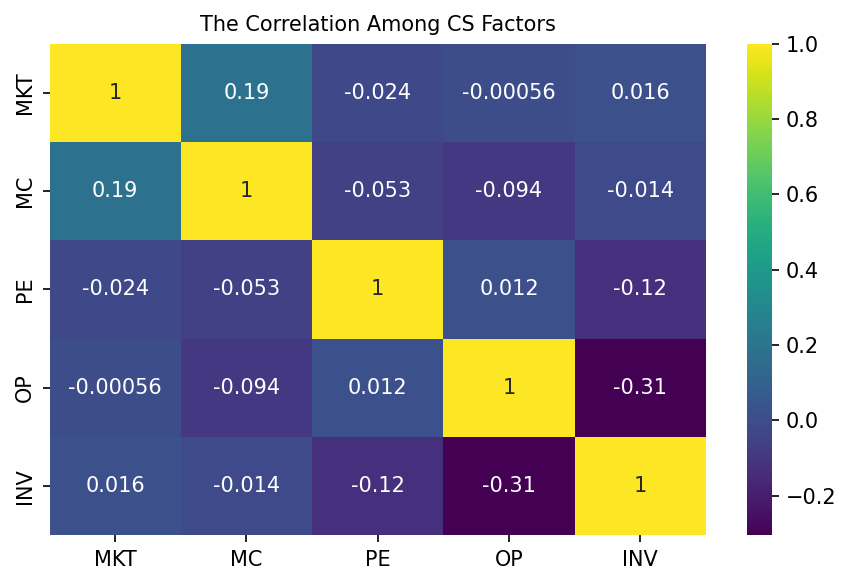

In [230]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_CS_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among CS Factors', fontsize=10)
plt.show()

In [231]:
# FF5CS-Factor Time Series Regression with Newey-West Adjustment
all_betas = []
all_std_errs = []
all_Rs_CS = []
all_sd_res_CS = []

betas = []
labels = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR.loc[:, j].dropna(
    ).index).intersection(df_CS_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_CS_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit()
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
        b = list(res.params)
        se = list(res.bse)
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs_CS.append(pd.DataFrame(Rs))
all_sd_res_CS.append(pd.DataFrame(sd_res))

100%|██████████| 740/740 [00:03<00:00, 193.75it/s]


In [232]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ZSA.SJ.Equity   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.194
Date:                Sun, 17 Apr 2022   Prob (F-statistic):            0.00706
Time:                        00:59:03   Log-Likelihood:                 7119.8
No. Observations:                2330   AIC:                        -1.423e+04
Df Residuals:                    2324   BIC:                        -1.419e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.756      0.449      -0.000       0.001
MKT            0.0023      0.016      0.141      0.888      -0.030       0.034
MC             0.4594      0.148      3.096      0.002       0.169       0.750
PE            -0.2250      0.147     -1.530      0.126      -0.513       0.063
OP             0.1526      0.162      0.944      0.345      -0.164       0.469
INV           -0.2272      0.170     -1.337      0.181      -0.560       0.106
==============================================================================
Omnibus:                      403.554   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7124.507
Skew:                           0.247   Prob(JB):                         0.00
Kurtosis:                      11.552   Cond. No.                         857.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [233]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
ABC.SJ.Equity,-0.004325,-0.248432,-2.730005,10.159118,-2.269599,3.260497
ABI.SJ.Equity,0.000279,0.257368,-0.257265,0.107787,-0.032924,-0.005279
ABK.SJ.Equity,-0.002682,0.358309,-1.164554,1.546209,-2.253111,5.235294
ABR.SJ.Equity,-0.005241,-0.274367,1.832379,-2.094345,-11.149353,-3.270059
ABU.SJ.Equity,-0.000561,0.015447,0.098374,-1.003282,0.494684,-0.768725
...,...,...,...,...,...,...
ZGOVI.SJ.Equity,0.000049,0.048153,-0.091700,-0.018617,-0.084377,-0.100206
ZPT.SJ.Equity,-0.002852,0.057928,0.596077,-1.840239,1.077203,-0.058892
ZRNHDG.SJ.Equity,-0.000359,0.035943,-0.134916,-0.047623,0.139875,0.187090


In [234]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
alphas = df_betas.iloc[:,0]
alphas.describe()

count    708.000000
mean      -0.000730
std        0.002423
min       -0.019595
25%       -0.000807
50%       -0.000082
75%        0.000254
max        0.006763
Name: Intercepts, dtype: float64

In [235]:
df_SE = pd.concat([all_std_errs[0], pd.DataFrame(labels)], axis = 1)
df_SE.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_SE = df_SE.set_index('Stocks')
df_SE

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
ABC.SJ.Equity,0.002707,0.337316,2.272346,2.443091,2.353905,2.168639
ABI.SJ.Equity,0.000314,0.036232,0.245011,0.249669,0.250772,0.248737
ABK.SJ.Equity,0.001615,0.144007,1.681711,1.700741,1.917492,2.282287
ABR.SJ.Equity,0.003541,0.402458,4.029085,3.114477,3.913463,3.427452
ABU.SJ.Equity,0.000615,0.044076,0.437086,0.608929,0.581706,0.508304
...,...,...,...,...,...,...
ZGOVI.SJ.Equity,0.000106,0.011292,0.082367,0.080439,0.079980,0.072178
ZPT.SJ.Equity,0.001317,0.162495,1.399618,1.422461,1.512068,1.315880
ZRNHDG.SJ.Equity,0.000341,0.020035,0.193914,0.242580,0.275241,0.265581


In [236]:
alphas_se = df_SE.iloc[:,0]
alphas_se.describe()

count    708.000000
mean       0.000781
std        0.000836
min        0.000008
25%        0.000287
50%        0.000514
75%        0.000963
max        0.009188
Name: Intercepts, dtype: float64

In [237]:
## Alpha Test (Fama & French, 2020)
### Step 1: Calculate t-statistics of alphas by using the formula: t-stats,i = alphas,i/s.e.(alphas,i)
alphas_t = alphas/alphas_se
alphas_t = alphas_t.replace(-np.inf,np.nan)
alphas_t.describe()

count    708.000000
mean      -0.337431
std        1.696897
min       -9.297348
25%       -1.155181
50%       -0.259634
75%        0.649072
max        7.757986
Name: Intercepts, dtype: float64

In [238]:
pd.DataFrame(alphas_t)

,Intercepts
Stocks,
ABC.SJ.Equity,-1.597882
ABI.SJ.Equity,0.887984
ABK.SJ.Equity,-1.660541
ABR.SJ.Equity,-1.480029
ABU.SJ.Equity,-0.912694
...,...
ZGOVI.SJ.Equity,0.461231
ZPT.SJ.Equity,-2.166085
ZRNHDG.SJ.Equity,-1.053322


#### Results_3

In [239]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(alphas))*21*100,np.nanmean(abs(alphas_t)))
### The mis-pricing errros is about 0.8% daily return, which is strongly significant

2.446357442083511 1.2328176016475354


In [240]:
### Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = np.var(df_SR.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(alphas))/cs_var)

0.9278182908207693


In [241]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean(pd.DataFrame(np.square(alphas).values)-pd.DataFrame(np.square(alphas_se).values))
print(A_lamda/cs_var)

0    0.738165
dtype: float64


/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [242]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs_CS)), 'As(a): ' + str(np.nanmean(alphas_se.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res_CS)*np.sqrt(21)))

AR^2: 0.07052810174866636 As(a): 0.0035780121170143437 As(e): 0.12830883906608437


In [243]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(alphas)/np.var(df_Ex_SR.mean()))

0.156721273543302

## The Correlation Between Betas and Characteristcs

In [244]:
TS_betas.iloc[:,1:]

,MKT,SMB,HML,RMW,CMA
Stocks,,,,,
ABC.SJ.Equity,-0.334855,-1.038481,2.287313,1.736295,0.155451
ABI.SJ.Equity,0.250634,-0.027526,-0.026816,-0.052584,0.015525
ABK.SJ.Equity,0.223503,-2.430166,2.617665,1.897113,0.505996
ABR.SJ.Equity,-0.389331,3.760604,-0.545912,1.553621,-0.163119
ABU.SJ.Equity,0.013298,0.056566,0.179378,-0.216206,-0.083836
...,...,...,...,...,...
ZGOVI.SJ.Equity,0.048067,-0.005870,-0.025272,-0.036429,-0.027054
ZPT.SJ.Equity,0.100060,-0.095590,-0.209509,0.405521,-0.727316
ZRNHDG.SJ.Equity,0.030242,0.154120,0.025129,-0.110328,-0.119765
